# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 3. Детекция объектов. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### Консультация 2023 года

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
import glob
import shutil
from pathlib import Path
from xml.etree import ElementTree as ET

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import ultralytics
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib.patches import Rectangle
from PIL import Image
from torch import nn
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

# !unzip -q data.zip

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [2]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.

        bbox = member.find("bndbox")
        class_name = member.find("name").text

        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        class_id = int(class_dict[class_name])

        res = [xmin, ymin, xmax, ymax, class_id]

        bboxes.append(res)

    return bboxes

In [3]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]  # получаем путь к файлу по индексу
        image = np.array(Image.open(fname))  # читаем изображение
        bboxes = get_xml_data(
            fname, self.root, self.class_dict
        )  # получаем bboxes из XML

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [5]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [6]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # Откатываем нормализацию и переставляем каналы
        img = images[i].permute(1, 2, 0)  # CHW -> HWC
        img = img * torch.tensor(std) + torch.tensor(mean)
        img = img.numpy()

        # Вот тут покажите картинку после отката нормализации
        ax.imshow(img)

        for bbox in bboxes[i]:
            # Вот тут нарисуйте бибоксы
            x_min, y_min, x_max, y_max, class_id = bbox

            # Создаем прямоугольник
            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                fill=False,
                color="red",
                linewidth=2,
            )
            ax.add_patch(rect)

            # Добавляем подпись класса
            class_name = train_ds.class_dict_inv[int(class_id)]
            ax.text(
                x_min,
                y_min - 5,
                class_name,
                color="red",
                fontsize=8,
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"),
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

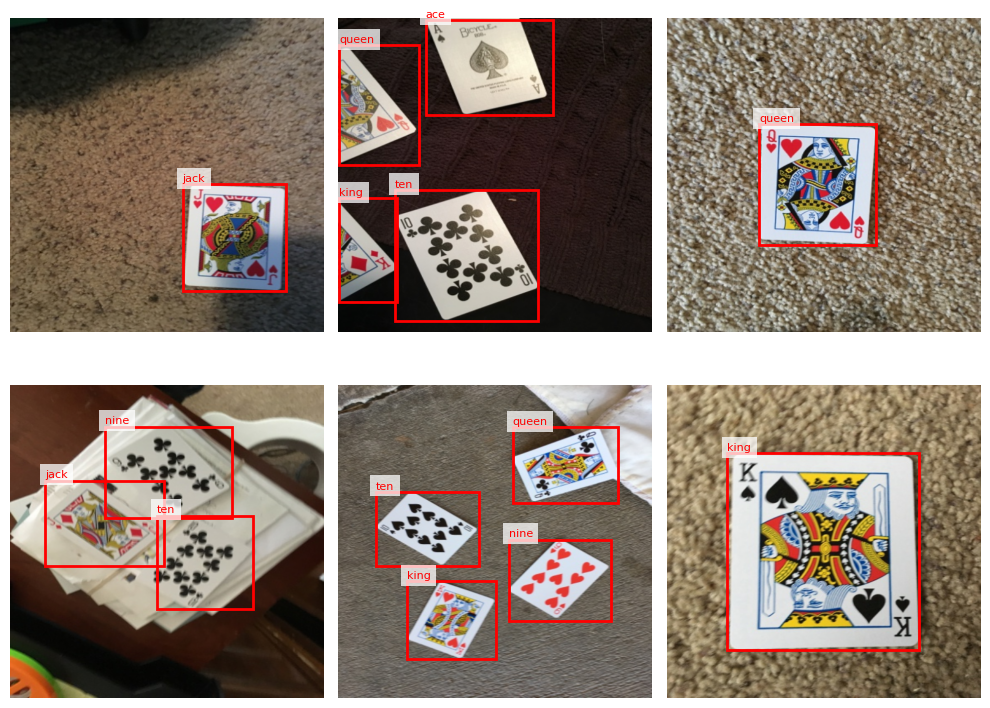

In [7]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код. 

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [8]:
def collate_fn(batch, downsample=32):
    # разделяем изображения и бибоксы
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))
    # собираем изображения в батч
    imgs = torch.stack(imgs)
    # получаем размеры батча, высоту и ширину изображения
    b, _, h, w = imgs.shape
    # создаем target - размер батча, 6 каналов, число клеток по высоте и ширине
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        # разделяем бибоксы на координаты и класс
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = w / (w // downsample)  # примерно downsample
        y_cell = h / (h // downsample)  #

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box = (
            xmax - xmin
        ) / w  # ширина бокса отнормированная на размер изначальной картинки
        h_box = (
            ymax - ymin
        ) / h  # высота бокса отнормированная на размер изначальной картинки

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2  # координаты центра в исходных координатах
        cy = (ymin + ymax) / 2
        cx_idx = (
            cx / x_cell
        ).long()  # Индекс центра на карте признаков размера 16x16. ...
        cy_idx = (
            cy / y_cell
        ).long()  # Это будут как раз координаты пикселя, куда мы запишем параметры коробки

        cx_box = (cx % x_cell) / x_cell  # сдвиг относительно cx_idx
        cy_box = (cy % y_cell) / y_cell  # сдвиг относительно cy_idx

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [
                cx_box,
                cy_box,  # сдвиги центра (2 канала)
                w_box,
                h_box,  # нормализованные размеры (2 канала)
                torch.ones_like(cx_box),  # confidence (1 канал)
                classes,  # класс (1 канал)
            ]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [9]:
def test_collate_fn() -> None:
    target1 = [100, 200, 200, 300, 2]  # xmin, ymin, xmax, ymax, class
    target2_1 = [0, 250, 200, 300, 0]  # xmin, ymin, xmax, ymax, class
    target2_2 = [0, 100, 100, 300, 1]  # xmin, ymin, xmax, ymax, class

    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": [target1]},
            {"image": torch.rand((3, 512, 512)), "bboxes": [target2_1, target2_2]},
        ]
    )

    # Проверяем размерности
    assert result["image"].shape == (2, 3, 512, 512)
    assert result["target"].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(
        result["target"][0, :, 7, 4],
        torch.tensor([22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2]),
    )
    assert np.allclose(
        result["target"][1, :, 8, 3],
        torch.tensor([4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0]),
    )
    assert np.allclose(
        result["target"][1, :, 6, 1],
        torch.tensor([18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1]),
    )

    # Проверяем, что все остальные клеточки содержат нули
    result["target"][0, :, 7, 4] = result["target"][1, :, 8, 3] = result["target"][
        1, :, 6, 1
    ] = torch.zeros(6)
    assert np.allclose(result["target"], 0)


test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

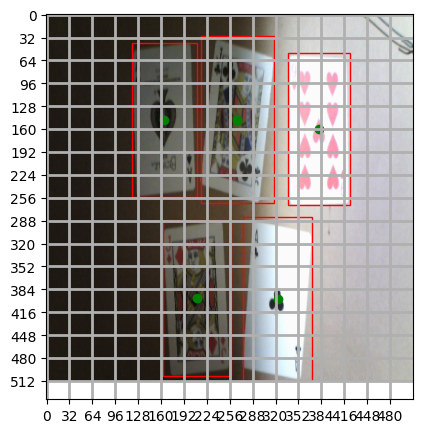

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=2)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему? 

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    # Находим индексы клеток, где confidence > threshold
    conf = pred[:, 4, :, :]  # канал "уверенности"
    idxs = torch.nonzero(conf > threshold)  # индексы клеток с C > threshold

    batch_idx, y_idx, x_idx = idxs[:, 0], idxs[:, 1], idxs[:, 2]

    # Сдвиги центра и нормализованные размеры для отфильтрованных клеток
    cx_box = pred[batch_idx, 0, y_idx, x_idx]  # относительный сдвиг по x
    cy_box = pred[batch_idx, 1, y_idx, x_idx]  # относительный сдвиг по y
    w_box = pred[batch_idx, 2, y_idx, x_idx]  # относительная ширина
    h_box = pred[batch_idx, 3, y_idx, x_idx]  # относительная высота

    # Определяем класс
    if c == 6:  # 6 каналов - это target из collate_fn
        classes = pred[batch_idx, 5, y_idx, x_idx].long()
    else:  # 6+ каналов - это предсказание модели
        class_probs = pred[batch_idx, 5:, y_idx, x_idx]  # вероятности классов
        classes = torch.argmax(
            class_probs, dim=1
        )  # выбираем класс с максимальной вероятностью

    # Восстанавливаем координаты центра бокса
    x_cell = img_w / w
    y_cell = img_h / h
    cx = (x_idx * x_cell) + (cx_box * x_cell)
    cy = (y_idx * y_cell) + (cy_box * y_cell)

    # Восстанавливаем ширину и высоту бокса
    width = w_box * img_w
    height = h_box * img_h

    # Вычисляем xmin, ymin, xmax, ymax
    xmin = cx - width / 2
    ymin = cy - height / 2
    xmax = cx + width / 2
    ymax = cy + height / 2

    # Собираем результат
    decoded_boxes = []
    for i in range(b):
        batch_mask = batch_idx == i  # маска для текущего батча
        if not batch_mask.any():  # если нет ни одного предсказания для текущего батча
            decoded_boxes.append([])  # добавляем пустой список
            continue

        i_xmin = xmin[batch_mask]
        i_ymin = ymin[batch_mask]
        i_xmax = xmax[batch_mask]
        i_ymax = ymax[batch_mask]
        i_classes = classes[batch_mask]

        # собираем результат в один тензор
        batch_result = torch.stack(
            [i_xmin, i_ymin, i_xmax, i_ymax, i_classes.float()], dim=-1
        )
        # конвертируем в список списков [[xmin, ymin, xmax, ymax, class_id], ...]
        decoded_boxes.append(batch_result.int().tolist())

    return decoded_boxes

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [12]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [[100, 200, 200, 300, 2]]
    target2 = [[0, 250, 200, 300, 0], [0, 100, 100, 300, 1]]
    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": target1},
            {"image": torch.rand((3, 512, 512)), "bboxes": target2},
        ]
    )

    target = result["target"]
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat(
        [target, torch.zeros(2, 2, 16, 16)], dim=1
    )  # Добавляем два канала
    assert target.shape == (2, 8, 16, 16)  # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([0.5, 0.6, 0.9])  # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([0.9, 0.6, 0.5])  # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([0.6, 0.9, 0.5])  # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print("Actual:  ", actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [target1, [target2[1], target2[0]]]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print("Expected:", expected)

    # Сравниваем
    assert actual == expected


test_decode_predictions()

Actual:   [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [13]:
#  {"king":0, "jack":1, "ace":2, "ten":3, "nine":4, "queen":5}
C = 6  # Количество классов в датасете


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # начало ResNet50 до layer4 включительно
        self.backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )

        # Уменьшаем количество каналов: 2048 -> 512 -> 128 -> 32 -> 5+C
        self.head = nn.Sequential(
            # шаг 1
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # шаг 2
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # шаг 3
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # финальная свертка
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1),
        )

    def forward(self, img):
        features = self.backbone(img)
        output = self.head(features)
        # применяем сигмоиду к финальному выходу
        return torch.sigmoid(output)

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [14]:
def special_loss(pred, target, C=C, lambda_noobj=0.1):
    # pred: [B, 5+C, H, W]
    # target: [B, 6, H, W]
    B, _, H, W = pred.shape

    mse_loss = nn.MSELoss(reduction="sum")
    ce_loss = nn.CrossEntropyLoss(reduction="sum")
    bce_loss_no_reduction = nn.BCELoss(reduction="none")

    # Маска наличия объекта в клетке
    # target[:, 4, :, :] содержит 1 там, где есть объект, и 0 иначе
    obj_mask = target[:, 4, :, :] == 1  # [B, H, W]
    noobj_mask = target[:, 4, :, :] == 0  # [B, H, W]

    # Расширяем маску для координат (2 канала)
    obj_mask_xy = obj_mask.unsqueeze(1).expand(B, 2, H, W)  # [B, 2, H, W]

    num_obj = obj_mask.sum().item()

    # 1. Localization Loss (координаты x,y)
    # Считаем только там, где есть объект
    loc_pred = pred[:, :2, :, :][obj_mask_xy]
    loc_target = target[:, :2, :, :][obj_mask_xy]
    localization_loss = mse_loss(loc_pred, loc_target)

    # 2. Box Loss (размеры w,h)
    # Считаем только там, где есть объект
    # Используем корень, добавляем 1e-6 для стабильности
    box_pred_sqrt = torch.sqrt(pred[:, 2:4, :, :].clamp(min=1e-6))[obj_mask_xy]
    box_target_sqrt = torch.sqrt(target[:, 2:4, :, :].clamp(min=1e-6))[obj_mask_xy]
    box_loss = mse_loss(box_pred_sqrt, box_target_sqrt)

    # 3. Classification Loss (класс объекта)
    # Считаем только там, где есть объект
    classification_loss = torch.tensor(0.0, device=pred.device)
    if num_obj > 0:
        # pred[:, 5:, :, :] содержит логиты или вероятности для C классов
        # target[:, 5, :, :] содержит индекс правильного класса
        class_pred = pred[:, 5:, :, :].permute(0, 2, 3, 1)[obj_mask]  # [num_obj, C]
        class_target = target[:, 5, :, :][obj_mask].long()  # [num_obj]
        classification_loss = ce_loss(class_pred, class_target)

    # Confidence Loss (уверенность в наличии объекта)
    # Считаем для всех клеток, но с разными весами
    conf_pred = pred[:, 4, :, :]  # Предсказанная уверенность  [B, H, W]
    conf_target = target[:, 4, :, :]  # Целевая уверенность (1 или 0)  [B, H, W]

    # Вычисляем BCE без редукции, чтобы применить веса
    conf_loss_all = bce_loss_no_reduction(conf_pred, conf_target)

    # Лосс для клеток с объектами (вес 1)
    conf_loss_obj = (conf_loss_all * obj_mask).sum()

    # Лосс для клеток без объектов (вес lambda_noobj)
    conf_loss_noobj = (conf_loss_all * noobj_mask).sum()

    confidence_loss = conf_loss_obj + lambda_noobj * conf_loss_noobj

    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 1 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [16]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

torch.manual_seed(21)
EPOCHS = 15  # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    model.train()
    epoch_losses = []
    for batch in pbar:
        images = batch["image"].to(device)
        targets = batch["target"].to(device)

        # Обнуляем градиенты
        opt.zero_grad()

        # Прямой проход
        outputs = model(images)

        # Расчет потерь
        loss = special_loss(outputs, targets, C=C)

        # Обратный проход и оптимизация
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": np.mean(epoch_losses)})

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Using device: mps


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.539;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 45.021;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 36.614;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 32.368;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 31.483;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 31.189;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 30.461;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 28.396;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 26.805;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 26.091;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 25.484;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 25.485;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 24.739;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 24.780;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 25.067;


Запустим обученный детектор на тестовых изображениях:

In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [18]:
# Нужно сделать предсказание и переложить результат на cpu

with torch.no_grad():
    pred = model(batch["image"].to(device))

# Декодируем предсказания
# Перемещаем тензор на CPU для декодирования
pred_cpu = pred.cpu()

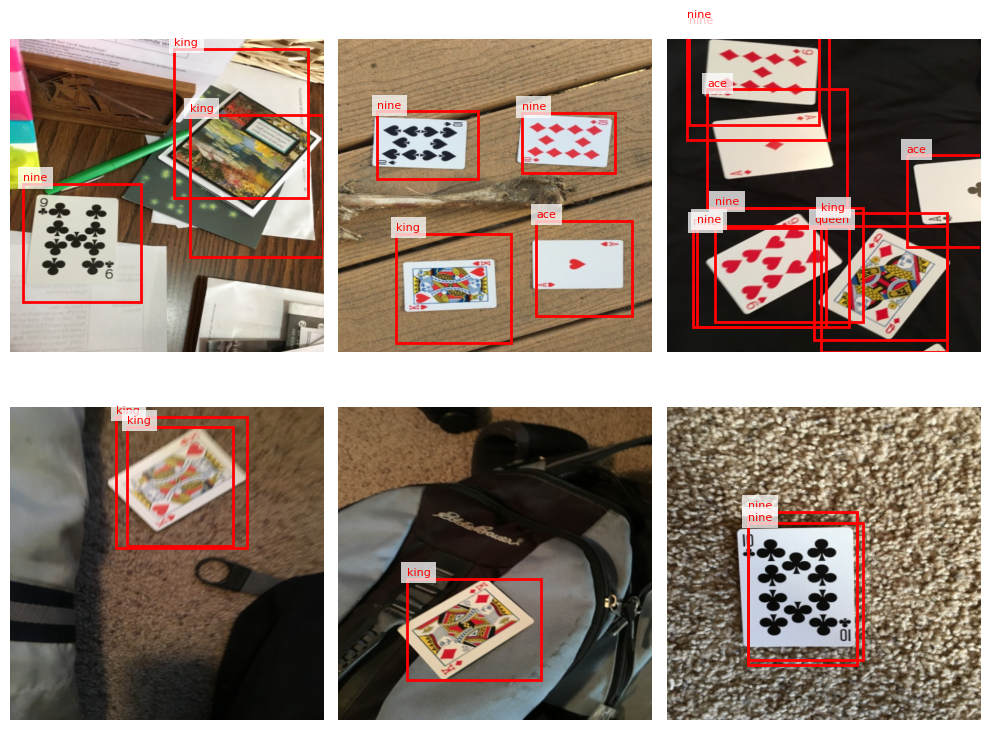

In [19]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

visualize(batch["image"].cpu(), decode_prediction(pred_cpu, threshold=0.15))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

> Да, результат не очень. Чтобы определилась "9" (справа вверху, рядом с Дамой), пришлось опустить порог до 0.15. Но из-за этого появилось много пересекающихся боксов.

# Задача 4 but better (1 балл)

## Прикручиваем NMS :^)

Напомним принцип работы алгоритма:
- Сортируем bbox в порядке убывания уверенности
- Считаем Intersection over Union (IoU) для всех bbox 
- Выкидываем все, пересечение с которыми больше порога
- Идем дальше по списку, пока не дойдем до конца

In [20]:
def NMS(bboxes, scores, iou_threshold=0.5):

    def box_iou(box1, box2):
        # координаты пересечения
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        # площадь пересечения
        intersection = max(0, x2 - x1) * max(0, y2 - y1)

        # площади боксов
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # IoU
        union = box1_area + box2_area - intersection

        return intersection / (union + 1e-6)

    if len(bboxes) == 0:
        return []

    # Получаем индексы в порядке убывания scores
    indices = np.argsort(scores)[::-1]

    keep = []  # индексы боксов, которые мы оставляем

    while indices.size > 0:
        # Берем бокс с наибольшим score
        current_idx = indices[0]
        keep.append(current_idx)

        if indices.size == 1:
            break

        # Вычисляем IoU между текущим боксом и всеми оставшимися
        ious = np.array(
            [box_iou(bboxes[current_idx], bboxes[idx]) for idx in indices[1:]]
        )

        # Оставляем только те боксы, у которых IoU меньше порога
        indices = indices[1:][ious < iou_threshold]

    return keep

In [21]:
def decode_prediction_nms(pred, upsample=32, threshold=0.7, iou_threshold=0.5):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    # Находим индексы клеток, где confidence > threshold
    conf = pred[:, 4, :, :]  # канал "уверенности"
    idxs = torch.nonzero(conf > threshold)  # индексы клеток с C > threshold

    batch_idx, y_idx, x_idx = idxs[:, 0], idxs[:, 1], idxs[:, 2]

    # Сдвиги центра и нормализованные размеры для отфильтрованных клеток
    cx_box = pred[batch_idx, 0, y_idx, x_idx]  # относительный сдвиг по x
    cy_box = pred[batch_idx, 1, y_idx, x_idx]  # относительный сдвиг по y
    w_box = pred[batch_idx, 2, y_idx, x_idx]  # относительная ширина
    h_box = pred[batch_idx, 3, y_idx, x_idx]  # относительная высота
    confidence = pred[batch_idx, 4, y_idx, x_idx]  # Уверенность

    # Определяем класс
    if c == 6:  # 6 каналов - это target из collate_fn
        classes = pred[batch_idx, 5, y_idx, x_idx].long()
    else:  # 6+ каналов - это предсказание модели
        class_probs = pred[batch_idx, 5:, y_idx, x_idx]  # вероятности классов
        classes = torch.argmax(
            class_probs, dim=1
        )  # выбираем класс с максимальной вероятностью

    # Восстанавливаем координаты центра бокса
    x_cell = img_w / w
    y_cell = img_h / h
    cx = (x_idx * x_cell) + (cx_box * x_cell)
    cy = (y_idx * y_cell) + (cy_box * y_cell)

    # Восстанавливаем ширину и высоту бокса
    width = w_box * img_w
    height = h_box * img_h

    # Вычисляем xmin, ymin, xmax, ymax
    xmin = cx - width / 2
    ymin = cy - height / 2
    xmax = cx + width / 2
    ymax = cy + height / 2

    # Собираем результат и применяем NMS для каждого изображения в батче
    decoded_boxes = []
    for i in range(b):
        batch_mask = batch_idx == i  # маска для текущего батча
        if not batch_mask.any():  # если нет ни одного предсказания для текущего батча
            decoded_boxes.append([])  # добавляем пустой список
            continue

        # Собираем все боксы и уверенности для текущего батча
        i_xmin = xmin[batch_mask].cpu().numpy()
        i_ymin = ymin[batch_mask].cpu().numpy()
        i_xmax = xmax[batch_mask].cpu().numpy()
        i_ymax = ymax[batch_mask].cpu().numpy()
        i_confidence = confidence[batch_mask].cpu().numpy()
        i_classes = classes[batch_mask].cpu().numpy()

        # Группируем боксы по классам и применяем NMS для каждого класса отдельно
        final_boxes = []
        for class_id in np.unique(i_classes):
            class_mask = i_classes == class_id
            if not class_mask.any():
                continue

            # Собираем боксы и уверенности для текущего класса
            curr_boxes = np.stack(
                [
                    i_xmin[class_mask],
                    i_ymin[class_mask],
                    i_xmax[class_mask],
                    i_ymax[class_mask],
                ],
                axis=-1,
            )
            curr_scores = i_confidence[class_mask]

            # Применяем NMS
            keep_idx = NMS(curr_boxes, curr_scores, iou_threshold=iou_threshold)

            # Сохраняем отфильтрованные боксы
            for idx in keep_idx:
                box = curr_boxes[idx]
                final_boxes.append([box[0], box[1], box[2], box[3], class_id])

        decoded_boxes.append(final_boxes)

    return decoded_boxes

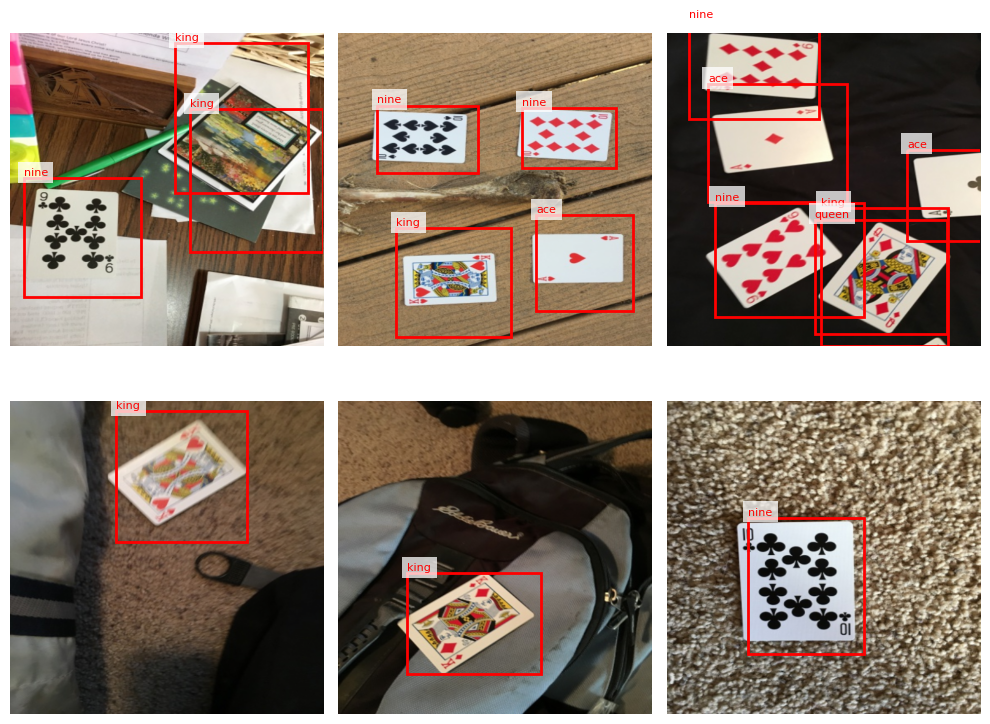

In [22]:
visualize(
    batch["image"].cpu(),
    decode_prediction_nms(pred_cpu, threshold=0.15, iou_threshold=0.5),
)

Лишние боксы для одинаковы классов отфильтрованы NMS.

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [ ]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###

    return

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики


for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names =  # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images
val: ../valid/images

nc: {nc}
names: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [ ]:
### YOUR CODE HERE ###

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
### YOUR CODE HERE ###

## Бонус (1 балл)

Реализуйте подсчет mAP для самописной модели. Если найдете готовый код на гитхабах -- используйте с указанием ссылок :)

Сравните свою модель с YOLO11. Что получается?